In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
    # np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds =10):
    # np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix

# # @jit(nopython = True)
# def sigma_check(p,degree):
#     sigma = np.zeros(p.shape[0])
#     for i in range(p.shape[0]):
#         sigma[i] = degree[i]*p[i].sum()
#     return sigma

In [3]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [4]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [5]:
def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [6]:
      
def convert_removing_to_inital(network_connection_removing):
    n,m = network_connection_removing.shape
    # print(n,m)
    index_matrix = np.zeros((n,m))
    for i in range(n):
        row = network_connection_removing[i,:]
        row_ind = row[np.where(row)]
        index_matrix[i,:len(row_ind)] = row_ind
#         print(index_matrix[i,:])
    del_col = []
    for j in range(m):
        col = index_matrix[:,j]
        if not np.any(col):
#             print(j)
            del_col.append(j)
    return np.delete(index_matrix,del_col,1)

def progressive_remove_connections(network_connection1, p1, num_removing_connections):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index1)] = 1
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    # num_removing_connections = int(sigma_difference/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), int(num_removing_connections), replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0
        
    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1)  
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1    
    
    return network_connection2,network_p2,network_degree2
  
def progressive_remove_connections_todegree(network_connection1, p1, k1):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index)] = 1
    
    korg = round(degree1.sum()/N,2)
    # print('korg is %f' %korg)
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections1 = int((korg-k)*N)
    # print(len(xy),num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections1, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0

    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1) 
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1  
    
    return network_connection2,network_p2,network_degree2    


In [7]:
# @jit(nopython = True)
def remove_node_connections_todegree(network_connection, K, avgd = 9 ):
    network_connection_clone = np.copy(network_connection)
    new_mean_degree = K
    
    while new_mean_degree > avgd:
        network_connection = remove_node_connections(network_connection_clone)
        new_degree = new_network_degree(network_connection)
        new_mean_degree = new_degree.mean()
    print(new_mean_degree)
    return  network_connection

# @jit(nopython = True)
def remove_ini_node_and_connections(network_connection1, p_value, ratio = 0.005, seeds = 10): 
    '''
        remove initial nodes and their assicated connections
        ratio should less than 0.005, in order to not affect the sigma
    '''
    
    # np.random.seed(seeds)
    N = network_connection1.shape[0]
    num_of_removed_node = int(ratio*N)
    # print(num_of_removed_node)
    remove_list = np.random.choice(N, size = num_of_removed_node, replace = False)
    # removing the node
    new_network_connection = np.delete(network_connection1, remove_list, axis = 0) 
    # print(new_network_connection.shape)
    # print(new_network_connection)
    # removing the node assicated connections
    for i in remove_list: # removing the node connections
      # new_network_connection[np.where(new_network_connection == i)] = 0
        node_connections_removing = np.where(new_network_connection == i)
        if node_connections_removing[0].size!=0:
            for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
                new_network_connection[i,j] = 0
      
    new_network_connection1 = convert_removing_to_inital(new_network_connection)
    # print(new_network_connection1)
    network_p1 = np.copy(new_network_connection1)
    network_p1[np.where(network_p1 != 0.0)] = p_value
    ## degree 
    network_index = np.copy(new_network_connection1)
    network_index[np.where(network_index)] = 1
    network_degree1 = np.sum(network_index,axis = 1)
    # print(network_degree1)
    return new_network_connection1, network_p1, network_degree1

# @jit(nopython = True)
def remove_connections_to_sigma(network_connection, network_p, degree, sigma, p_value = 0.1,  seeds = 10):
    # p_value, the propagation rate 
    # the wanted sigma
    np.random.seed(seeds)
    ini_sigma = round(np.sum(degree)/N)*p_value
    if sigma>ini_sigma:
        raise NameError('the traget sigma should less than initial sigma')
        
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int((ini_sigma-sigma)/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return network_connection,network_p,new_degree


In [8]:
def init_network(K, N = 10**5, p_value = 1e-1):    
    # K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
    # p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone)
    # ## propagation matrix 
    network_p = np.copy(network_connection)
    network_p[np.where(network_p != 0.0)] = p_value
    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    
    return network_connection, network_degree, network_p

# progressively remove network degree k with fixed p_vlaue
def aging_network(network_connection1, network_degree1, network_p1, p_vlaue = 0.1, ratio = 0.0005, sigma_step = 0.01, times = 1000):
     
    network_connection_clone = np.copy(network_connection1)
    network_degree_clone = np.copy(network_degree1)
    network_p_clone = np.copy(network_p1)
    N = network_connection_clone.shape[0]
    
    # comment out followings to removing initial nodes
    network_connection2, network_p2, network_degree2 = remove_ini_node_and_connections(network_connection1, p_vlaue, ratio)
    network_connection_clone = np.copy(network_connection2)
    network_degree_clone = np.copy(network_degree2)
    # print(degree_clone)
    network_p_clone = np.copy(network_p2)
    N = network_connection_clone.shape[0]

    max_sigma = round(network_degree_clone.sum()/N*p_vlaue,2)
    print('==> ==> inital sigma: %f'%max_sigma)
      
    num_removing_connections_each_setp = sigma_step*N/p_vlaue
    traget_sigma = np.arange(0.6, max_sigma, sigma_step)
    print(traget_sigma)
    
    
    times1 = times
    r = 1/N
    n = 10
    t_test1 = np.arange(times1)
    p_vlaue1 = p_vlaue
    print('==> ==> ==> sigma with aging: %f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
    
    rho = []
    sigmas = []
    taus = []
    F0 = []
    # degrees = []
    
    # degrees.append(network_degree_clone)
    
    rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times1, r, times1, n)
    rho.append(rho_test)
    tau = decay(rho_test[50:],25)
    taus.append(tau[1])
    sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
    F0.append(F0_determine(rho_test))

    j = 0
    while j<len(traget_sigma):
        
        
        network_connection3, network_p3, network_degree3 = \
            progressive_remove_connections(network_connection_clone, p_vlaue1,\
                                           num_removing_connections_each_setp)

        network_degree_clone = np.copy(network_degree3)
    #     print(degree_clone)
        network_connection_clone = np.copy(network_connection3)
        network_p_clone = np.copy(network_p3)

        # degrees.append(network_degree)
        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        rho.append(rho_test)
        tau = decay(rho_test[50:],25)
        taus.append(tau[1])
        sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
        print('==> ==> ==> sigma with aging: %.2f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
        # print(round(network_degree_clone.mean(),2)*p)
        F0.append(F0_determine(rho_test))

        j = j +1
    return rho,sigmas,taus,F0

In [108]:
gmv_diff_df = pd.read_csv('Aging_network/gmv_diff_df.csv')
print(gmv_diff_df)
GMV_ratio = gmv_diff_df['GMV_ratio'].values
# GMV_ratio

      Group  GMV_ratio  GMV_nodes
0     Young   0.000427      99958
1     Young   0.000955      99905
2     Young   0.002142      99786
3     Young   0.003331      99667
4     Young   0.001459      99855
5     Young   0.000199      99981
6     Young   0.001557      99845
7     Young   0.001813      99819
8     Young   0.001725      99828
9     Young   0.000220      99979
10    Young   0.000153      99985
11    Young   0.002543      99746
12    Young   0.004365      99564
13    Young   0.002928      99708
14    Young   0.002711      99729
15    Young   0.000921      99908
16    Young   0.001927      99808
17    Young   0.003244      99676
18    Young   0.001988      99802
19    Young   0.001728      99828
20    Young   0.001467      99854
21    Young   0.003079      99693
22    Young   0.002433      99757
23    Young   0.002539      99747
24    Young   0.000595      99941
25    Young   0.000333      99967
26    Young   0.004672      99533
27    Young   0.001999      99801
28    Young   

In [10]:
k = 10
times = 5050
network_connection,  network_degree, network_p = init_network(k)
print('********************************')
print('Generated network with avaerage degree k = %d '%(k))
print('********************************')
for i, gmv_ratio in enumerate(GMV_ratio):
  print(gmv_ratio)
  rho,sigmas,taus,F0 = aging_network(network_connection, network_degree, network_p,\
                                      p_vlaue = 0.1, ratio = gmv_ratio, sigma_step = 0.01, times = times)
  scio.savemat(f'Aging_network/gmv_rnode_K10_Timeseries_{i+1}_{times}.mat',{'sigmas':sigmas,'rho':rho,'intf':taus,'F0':F0})

********************************
Generated network with avaerage degree k = 10 
********************************
0.0004274632833728
==> ==> inital sigma: 1.000000
[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
==> ==> ==> sigma with aging: 1.000000
==> ==> ==> sigma with aging: 0.99
==> ==> ==> sigma with aging: 0.98
==> ==> ==> sigma with aging: 0.97
==> ==> ==> sigma with aging: 0.96
==> ==> ==> sigma with aging: 0.95
==> ==> ==> sigma with aging: 0.94
==> ==> ==> sigma with aging: 0.93
==> ==> ==> sigma with aging: 0.92
==> ==> ==> sigma with aging: 0.91
==> ==> ==> sigma with aging: 0.90
==> ==> ==> sigma with aging: 0.89
==> ==> ==> sigma with aging: 0.88
==> ==> ==> sigma with aging: 0.87
==> ==> ==> sigma with aging: 0.86
==> ==> ==> sigma with aging: 0.85
==> ==> ==> sigma with aging: 0.84
==> ==> ==> sigma with aging: 0.83

# without connection removal 

In [115]:
without_conn = {}
without_conn['Group'] = ['Young']*30 + ['Elderly']*30
without_conn['tau'] = []
for i, nodes in enumerate(GMV_ratio):
  # print(i, nodes)
  # break
  timeseries = scio.loadmat(f'Aging_network/gmv_rnode_K10_Timeseries_{i+1}_{times}.mat')
  sigmas = timeseries['sigmas'][0][1] 
  taus = timeseries['intf'][0][1]
  # print(taus)
  without_conn['tau'].append(taus)

without_conn_df = pd.DataFrame(without_conn)
without_conn_df.to_csv('./Aging_network/gmv_rnode_K10_distribution_withoutconn.csv',index = False)

In [15]:
intt_diff_df = pd.read_csv('int_diff_df.csv')

print(intt_diff_df)
intt_sigma_df = intt_diff_df['int_sigma_diff'].values
intt_sigma_df

    Unnamed: 0    Group  int_sigma_diff  Connections  Unnamed: 4  Unnamed: 5
0          0.0    Young        0.822031     822031.0         NaN        0.82
1          1.0    Young        0.977814     977813.0         NaN        0.98
2          2.0    Young        0.947749     947749.0         NaN        0.95
3          3.0    Young        0.770171     770171.0         NaN        0.77
4          4.0    Young        0.904597     904596.0         NaN        0.90
..         ...      ...             ...          ...         ...         ...
56        56.0  Elderly        0.795622     795621.0         NaN        0.80
57        57.0  Elderly        0.742830     742829.0         NaN        0.74
58        58.0  Elderly        0.731613     731613.0         NaN        0.73
59        59.0  Elderly        0.809593     809592.0         NaN        0.81
60         NaN      NaN             NaN          NaN         NaN        0.00

[61 rows x 6 columns]


array([0.82203133, 0.97781373, 0.94774931, 0.77017122, 0.90459679,
       0.95611368, 0.67308487, 0.981497  , 0.89232828, 0.89499758,
       0.93541198, 0.96840386, 0.9080161 , 0.76111985, 0.87054203,
       0.93050043, 0.93632799, 0.97307281, 0.95574532, 0.97631916,
       0.81824542, 0.94698816, 0.93901194, 0.93410512, 0.95664967,
       0.96624667, 0.84177148, 0.91157315, 0.9186966 , 0.78275199,
       0.67298395, 0.71123237, 0.65402248, 0.81126944, 0.69975957,
       0.82229815, 0.68442195, 0.84392672, 0.64781698, 0.85171742,
       0.79836151, 0.86154009, 0.77239995, 0.8139245 , 0.63386234,
       0.80706164, 0.74039709, 0.97056014, 0.68371548, 0.73955032,
       0.80299043, 0.70580481, 0.74216408, 0.80236318, 0.75980448,
       0.86482411, 0.79562191, 0.74282987, 0.73161329, 0.80959275,
              nan])

# connection removal 

In [17]:
sigma_diff = [round(s,2) for s in intt_sigma_df[:-1]]
print(sigma_diff)
times = 5050
approaching_int_difference = {}
approaching_int_difference['sigmas'] = sigma_diff
approaching_int_difference['rho'] = []
approaching_int_difference['intf'] = []
approaching_int_difference['F0'] = []
for i, sigma in enumerate(sigma_diff):
    print(sigma)
    timeseries = scio.loadmat(f'Aging_network/gmv_rnode_K10_Timeseries_{i+1}_{times}.mat')
    sigmas = timeseries['sigmas'][0]
    rho = timeseries['rho']
    taus = timeseries['intf'][0]
    F0 = timeseries['F0'][0]
    ind = np.where(sigmas == sigma)[0][0]
#     print(taus)
    approaching_int_difference['rho'].append(rho[ind])
    approaching_int_difference['intf'].append(taus[ind])
    approaching_int_difference['F0'].append(F0[ind])

# scio.savemat(f'Aging_network/sigma_diff_gmv_rnode_K10_distribution.mat',\
#              {'sigmas':approaching_int_difference['sigmas'],\
#               'rho':approaching_int_difference['rho'],\
#               'intf':approaching_int_difference['intf'],\
#               'F0':approaching_int_difference['F0']})

[0.82, 0.98, 0.95, 0.77, 0.9, 0.96, 0.67, 0.98, 0.89, 0.89, 0.94, 0.97, 0.91, 0.76, 0.87, 0.93, 0.94, 0.97, 0.96, 0.98, 0.82, 0.95, 0.94, 0.93, 0.96, 0.97, 0.84, 0.91, 0.92, 0.78, 0.67, 0.71, 0.65, 0.81, 0.7, 0.82, 0.68, 0.84, 0.65, 0.85, 0.8, 0.86, 0.77, 0.81, 0.63, 0.81, 0.74, 0.97, 0.68, 0.74, 0.8, 0.71, 0.74, 0.8, 0.76, 0.86, 0.8, 0.74, 0.73, 0.81]
0.82
0.98
0.95
0.77
0.9
0.96
0.67
0.98
0.89
0.89
0.94
0.97
0.91
0.76
0.87
0.93
0.94
0.97
0.96
0.98
0.82
0.95
0.94
0.93
0.96
0.97
0.84
0.91
0.92
0.78
0.67
0.71
0.65
0.81
0.7
0.82
0.68
0.84
0.65
0.85
0.8
0.86
0.77
0.81
0.63
0.81
0.74
0.97
0.68
0.74
0.8
0.71
0.74
0.8
0.76
0.86
0.8
0.74
0.73
0.81


In [12]:
approaching_int_difference['Group'] = ['Young']*30+['Elderly']*30
approaching_int_difference_df = pd.DataFrame(approaching_int_difference)
print(approaching_int_difference_df)
approaching_int_difference_df.to_csv('Aging_network/Approaching_int_difference_df.csv',index =False)

    sigmas                                                rho       intf  \
0     0.82  [0.007963344604733988, 0.0012405210188279076, ...   6.105127   
1     0.98  [0.009819328361943847, 0.0018417496621790702, ...  20.936327   
2     0.95  [0.009049365642474896, 0.001723688693804742, 0...  13.786779   
3     0.77  [0.007294289985652222, 0.0011739091173608115, ...   3.883588   
4     0.90  [0.008722647839367083, 0.0013820039056632117, ...   8.303034   
5     0.96  [0.008951700823156399, 0.0015302907552434963, ...  15.721253   
6     0.67  [0.006389904351745205, 0.0007812108768591317, ...   2.591375   
7     0.98  [0.010018132820404932, 0.0018433364389545076, ...  29.591252   
8     0.89  [0.008454541811916497, 0.0016929118083102938, ...   9.141613   
9     0.89  [0.007621600536112583, 0.0013602856599885976, ...   9.778324   
10    0.94  [0.0087113066960044, 0.0016802520378056708, 0....  22.075338   
11    0.97  [0.009484089587552383, 0.0016140998135263569, ...  20.937972   
12    0.91  

In [2]:
approaching_int_difference_df = pd.read_csv('Aging_network/Approaching_int_difference_df.csv')
approaching_int_difference_df

,sigmas,rho,intf,F0,Group
0,0.82,[7.96334460e-03 1.24052102e-03 3.20134456e-04 ...,6.105127,0.000071,Young
1,0.98,[0.00981933 0.00184175 0.00052049 ... 0.000250...,20.936327,0.000440,Young
2,0.95,[9.04936564e-03 1.72368869e-03 4.81029403e-04 ...,13.786779,0.000219,Young
3,0.77,[7.29428999e-03 1.17390912e-03 2.30768459e-04 ...,3.883588,0.000056,Young
4,0.90,[8.72264784e-03 1.38200391e-03 3.40493716e-04 ...,8.303034,0.000102,Young
5,0.96,[8.95170082e-03 1.53029076e-03 4.30081716e-04 ...,15.721253,0.000228,Young
6,0.67,[6.38990435e-03 7.81210877e-04 1.70263909e-04 ...,2.591375,0.000039,Young
7,0.98,[0.01001813 0.00184334 0.00042076 ... 0.001292...,29.591252,0.000300,Young
8,0.89,[8.45454181e-03 1.69291181e-03 5.00861482e-04 ...,9.141613,0.000100,Young
9,0.89,[0.0076216 0.00136029 0.00040008 ... 0.000110...,9.778324,0.000109,Young


In [11]:
import scipy.stats as stats
# from bioinfokit.analys import stat,get_data
from statsmodels.stats.multitest import multipletests

tvalue, pvalue = stats.ttest_ind(approaching_int_difference_df['intf'][:30],approaching_int_difference_df['intf'][30:],equal_var = False)
print(tvalue, pvalue )

5.564151384229141 2.7562346756499136e-06


In [73]:
sorted_sig = sorted(intt_sigma_df)
print(sorted_sig)
sorted_id =  np.argsort(intt_sigma_df)
print(sorted_id)
sorted_tau = np.array(approaching_int_difference['intf'])[sorted_id]
print(sorted_tau)
colors = np.array(['red' if i>30 else 'blue' for i in sorted_id])
print(colors)


[0.6338623358014319, 0.6478169782617698, 0.6540224833408818, 0.6729839483799094, 0.6730848689141848, 0.6837154819852321, 0.6844219494353705, 0.699759567383471, 0.7058048061622857, 0.7112323740000829, 0.7316132907242342, 0.7395503170819735, 0.7403970898094142, 0.742164083392802, 0.742829873560594, 0.7598044851561512, 0.7611198460835669, 0.7701712217478163, 0.7723999468498384, 0.7827519912421568, 0.7956219091048742, 0.798361506654015, 0.8023631801440375, 0.8029904266935238, 0.8070616426468594, 0.8095927463800722, 0.8112694440395563, 0.8139244966264706, 0.8182454212056789, 0.8220313256488629, 0.8222981531965972, 0.8417714752863306, 0.8439267161629849, 0.851717417192171, 0.8615400864187777, 0.8648241124134033, 0.8705420312651976, 0.8923282843237125, 0.8949975818702854, 0.904596794315874, 0.9080161025599868, 0.9115731502555277, 0.9186966044801804, 0.9305004287575992, 0.9341051241935212, 0.9354119779579952, 0.9363279932464056, 0.9390119443510456, 0.9469881610279012, 0.9477493127470796, 0.955

In [4]:
approaching_int_difference = pd.read_csv('Aging_network/Approaching_int_difference_df.csv')

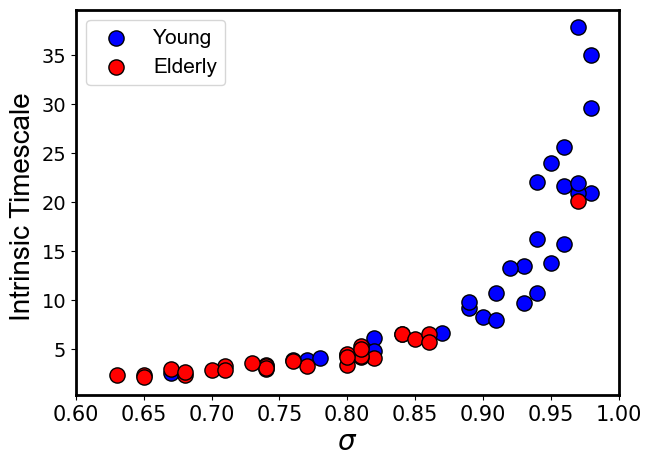

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
# print(approaching_int_difference['sigmas'][:15])
# print(approaching_int_difference['intf'][:15])


# ax.plot(sorted_sig, sorted_tau,linewidth = 2.2, linestyle = '-', color = 'black')
ax.scatter(approaching_int_difference['sigmas'][:30], approaching_int_difference['intf'][:30], \
        s = 120, marker = 'o',linewidths = 1,edgecolors = 'black', color = 'blue', label = 'Young')
ax.scatter(approaching_int_difference['sigmas'][30:], approaching_int_difference['intf'][30:], \
        s = 120, marker = 'o',linewidths = 1,edgecolors = 'black', color = 'red',label = 'Elderly')
# ax.set_xlabel('$\sigma$',fontsize=27)
# ax.set_ylabel('$INt_f$ ',fontsize= 27)
# # ax.set_title('Transition test',fontsize=32)
# plt.xticks(fontsize= 12)
# plt.yticks(fontsize= 12)
# bwith = 2 
ax.set_xlabel('$\sigma$',fontsize= 20, family ='Arial')
ax.set_ylabel('Intrinsic Timescale ',fontsize= 20,family ='Arial')
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(np.arange(0.6,1.01,0.05),fontsize= 15)
plt.yticks(fontsize= 14)
font_prop = font_manager.FontProperties(size = 15, weight = 4, family = 'Arial')
labels = ax.get_xticklabels() + ax.get_yticklabels()
ax.legend(prop = font_prop)

bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
#设置边框
ax.spines['bottom'].set_linewidth(bwith)#图框下边
ax.spines['left'].set_linewidth(bwith)#图框左边
ax.spines['top'].set_linewidth(bwith)#图框上边
ax.spines['right'].set_linewidth(bwith)#图框右边
#取消边框

# plt.grid(color = 'black',linewidth = 1,alpha=0.4)
# plt.savefig(f'Aging_network/int_vs_sigma4.png', dpi=400, bbox_inches='tight')
# plt.close()